In [2]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [4]:
img_height, img_width = (244,244)
batch_size = 32

train_data_dir = r"/content/drive/MyDrive/BrainTumor/OriginalImages/Training"
valid_data_dir = r"/content/drive/MyDrive/BrainTumor/OriginalImages/Testing"
test_data_dir = r"/content/drive/MyDrive/BrainTumor/OriginalImages/Testing"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, shear_range=0.2,zoom_range=0.2,horizontal_flip=True, validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 1724 images belonging to 4 classes.
Found 157 images belonging to 4 classes.


In [6]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation')

Found 157 images belonging to 4 classes.


In [7]:
x,y = test_generator.next()
x.shape

(1, 244, 244, 3)

In [14]:
base_model = ResNet50(include_top=False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_generator, epochs = 150)

Epoch 1/150
54/54 [==============================] - 33s 563ms/step - loss: 1.1350 - accuracy: 0.6833
Epoch 2/150
54/54 [==============================] - 34s 632ms/step - loss: 0.3980 - accuracy: 0.8492
Epoch 3/150
54/54 [==============================] - 30s 552ms/step - loss: 0.3162 - accuracy: 0.8799
Epoch 4/150
54/54 [==============================] - 30s 558ms/step - loss: 0.2953 - accuracy: 0.8846
Epoch 5/150
54/54 [==============================] - 29s 541ms/step - loss: 0.2407 - accuracy: 0.9084
Epoch 6/150
54/54 [==============================] - 30s 546ms/step - loss: 0.2121 - accuracy: 0.9194
Epoch 7/150
54/54 [==============================] - 29s 544ms/step - loss: 0.1800 - accuracy: 0.9356
Epoch 8/150
54/54 [==============================] - 29s 541ms/step - loss: 0.1892 - accuracy: 0.9292
Epoch 9/150
54/54 [==============================] - 29s 538ms/step - loss: 0.2115 - accuracy: 0.9234
Epoch 10/150
54/54 [==============================] - 29s 540ms/step - loss: 0.166

In [24]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

157/157 - 4s - loss: 5.5280 - accuracy: 0.5669 - 4s/epoch - 23ms/step


In [21]:
print('\nTest accuracy:',test_acc)


Test accuracy: 0.5732483863830566


In [25]:
model.save("/content/save.h5")

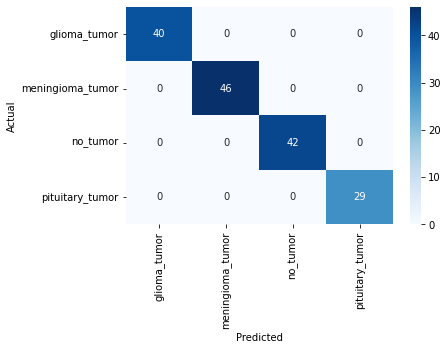

test accuracy : ()


In [29]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model("/content/save.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(Y_test)
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : ()'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))